# Note on ball-drop source characteristics

2025.3.14 Kurama Okubo

In [2]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import matplotlib as mpl

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

# Compute force-time function of ball-drop impact

In [38]:
def stf_herzian_mclaskey2009(t, rho, R, v, E1, nu1, E2, nu2):
    '''
        source time function of Herzian solution
    '''
    def get_delta(E1, mu1, E2, mu2):
        del1 = (1-nu1**2)/(np.pi*E1)
        del2 = (1-nu2**2)/(np.pi*E2)
        return (del1, del2)
    
    
    def get_contact_time(rho, del1, del2, R, v):
        return 4.53*(( 4*rho  * np.pi * (del1 + del2) /3 )**(2/5)) * R * (v **(-1/5))

    def get_maximum_force(rho, del1, del2, R, v):
        return 1.917 * (rho**(3/5)) * ((del1 + del2)**(-2/5)) * (R**2) * (v**(6/5))

        
    del1, del2 = get_delta(E1, nu1, E2, nu2)
    
    # print(del1, del2, rho, R, v)
    tc = get_contact_time(rho, del1, del2, R, v)
    fmax = get_maximum_force(rho, del1, del2, R, v)
    print(f"tc, fmax={tc}, {fmax}")
    
    stf = np.zeros(len(t))
    for i, tt in enumerate(t):
        if 0<tt and tt < tc:
            stf[i] = fmax*(np.sin(np.pi*tt/tc))**(3/2)
        else:
            stf[i] = 0
            
    return stf, tc, fmax


In [39]:
# Compute cosine source
dt = 1e-7
tlen = 10e-6
tvec_STF = np.arange(np.ceil(tlen/dt)) * dt

In [40]:
# Compute Ball constants from McLaskey and Glaser 2010.
rho1 = 7781.1
cp_ball  = 5900
cs_ball  = 3230

#shear modulus
G1 = rho1 * (cs_ball **2) #[Pa]
# poisson's ratio of rock
vpvs_ball = cp_ball/cs_ball
nu1  = 0.5 * (((vpvs_ball**2) - 2.0) / ((vpvs_ball**2) - 1.0))
# Young's modulus of rock
E1 = 2.0 * G1 * (1+nu1) # [Pa]

# Rock block constants
rho2 = 2980
cp_rock  = 6200 #6919
cs_rock  = 3600 #3631

#shear modulus
G2 = rho2 * (cs_rock **2) #[Pa]
# poisson's ratio of rock
vpvs_rock = cp_rock/cs_rock
nu2  = 0.5 * (((vpvs_rock**2) - 2.0) / ((vpvs_rock**2) - 1.0))
# Young's modulus of rock
E2 = 2.0 * G2 * (1+nu2) # [Pa]

print(E1/1e9, nu1)
print(E2/1e9, nu2, G2/1e9)

R = 1.0e-3 # ball radius for tha case of 4m ball-drop test.
h = 0.500 # [m] dropped 500mm for tha case of 4m ball drop.
g = 9.80665
v = np.sqrt(2*g*h)

ft_herz_mc_4m, tc, fmax = stf_herzian_mclaskey2009(tvec_STF, rho1, R, v, E1, nu1, E2, nu2)

208.7951761042903 0.28601023091343925
96.2185394034537 0.24568288854003145 38.6208
tc, fmax=6.665053658412358e-06, 56.305840145428625


In [77]:
Nzero = 2**8
rfft_signal_bd = np.fft.rfft(ft_herz_mc_4m, Nzero)
rfft_freq_bd   = np.fft.rfftfreq(Nzero, dt)

In [78]:
cornerfreq = 1/tc # approximation of corner frequency
print(f"corner frequency approximation: {cornerfreq/1e3:.2f} kHz with the ball radius of {R*1e3} mm")

corner frequency approximation: 150.04 kHz with the ball radius of 1.0 mm


In [82]:
# derivative of force-time function
d_ft_herz_mc_4m = np.gradient(ft_herz_mc_4m, dt)
rfft_signal_bd_d = np.fft.rfft(d_ft_herz_mc_4m, Nzero)


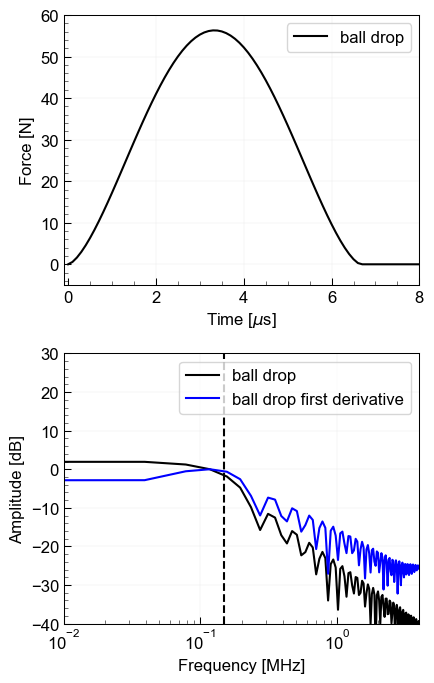

In [97]:
fig, axs = plt.subplots(2, 1, figsize=(4.5,7))

axs[0].plot(tvec_STF*1e6, ft_herz_mc_4m, c="black", ls="-", label='ball drop')
# axs[0].plot(tvec_STF*1e6, d_ft_herz_mc_4m/1e7, c="b", ls="-", label='ball drop')
axs[0].set_xlabel(r"Time [$\mu$s]")
axs[0].set_ylabel("Force [N]")
# axs[0].legend(fontsize=fontsize)

axs[0].set_xlim(-.1, 8)
axs[0].set_ylim(-5, 60)
axs[0].legend(loc=1)

ampref_freq = np.where(rfft_freq_bd>0.1e6)[0][0]
                       
pw_dB_bd = 10*np.log10(np.abs(rfft_signal_bd)/np.abs(rfft_signal_bd[ampref_freq]))
pw_dB_bd_d = 10*np.log10(np.abs(rfft_signal_bd_d/np.abs(rfft_signal_bd_d[ampref_freq])))

axs[1].plot(rfft_freq_bd/1e6, pw_dB_bd,"k-", label='ball drop')
axs[1].plot(rfft_freq_bd/1e6, pw_dB_bd_d,"b-", label='ball drop first derivative')
axs[1].set_xscale('log')
axs[1].set_xlabel("Frequency [MHz]")
axs[1].set_ylabel("Amplitude [dB]")
axs[1].set_xlim(0.01, 4)
axs[1].set_ylim(-40, 30)
axs[1].legend(loc=1)
axs[1].axvline(cornerfreq/1e6, c="k", ls="--")

for ax in axs:
    ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1, which="major")
    ax.set_axisbelow('True')

plt.tight_layout()
foname = "./stf_balldrop_R{0:.1f}mm_h{1:.0f}mm.png".format(R*1e3, h*1e3)
plt.savefig(foname, dpi=70)